In [1]:
import sys
import tqdm
import torch
import numpy as np
import scanpy as sc
import pyarrow.parquet as pq

from transformers import T5Tokenizer, T5EncoderModel

torch.set_float32_matmul_precision('medium')

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
parquet_path = "../data/frustration/v3_frustration.parquet.gzip"
df = pq.read_table(parquet_path).to_pandas()
df = df.sample(n=100, random_state=42).reset_index(drop=True)

## ProstT5

In [102]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pLM_model = "../data/prostT5"
prefix_prostT5 = "<AA2fold>"
max_seq_length = 256
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

if "cuda" in device:
    encoder.half()
    print("Using half precision for the pLM encoder")

In [103]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [prefix_prostT5 + " " + " ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, 1:idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx-1])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx-1])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx-1])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class"]
    frst_class.append(classes[:idx-1])


100it [00:34,  2.88it/s]


In [104]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')

In [105]:
adata

AnnData object with n_obs × n_vars = 24481 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [106]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst

AnnData object with n_obs × n_vars = 10997 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [107]:
sc.pp.pca(adata_frst)
sc.pp.neighbors(adata_frst)
sc.tl.umap(adata_frst)

In [108]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [109]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

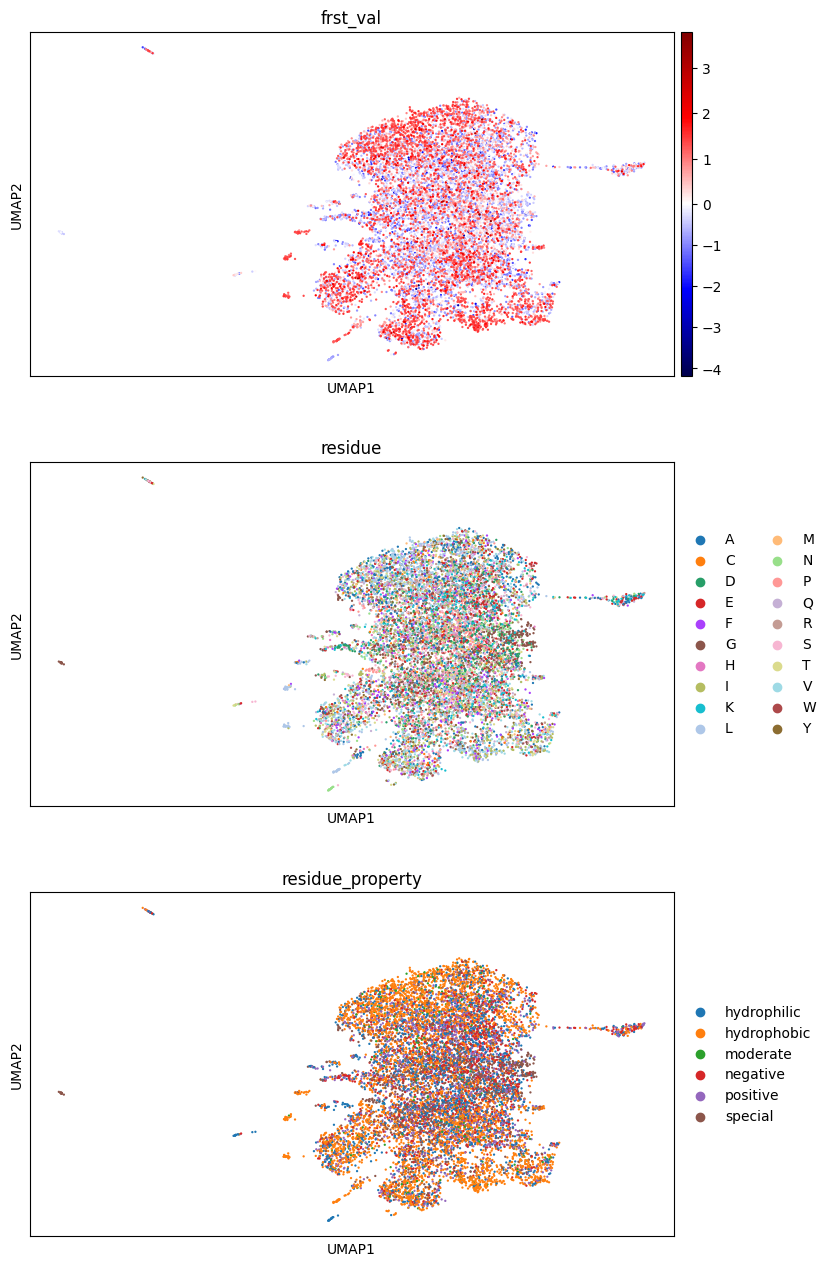

In [110]:
sc.pl.umap(adata_frst, color=['frst_val', 'residue', "residue_property"], ncols=1, wspace=0.4, cmap='seismic', vcenter=0,) #palette="tab20")

In [73]:
len(df.iloc[0]["full_seq"])

309

In [74]:
full_seq = [prefix_prostT5 + " " + " ".join(df.iloc[0]["full_seq"])]
ids = tokenizer.batch_encode_plus(full_seq,
                                add_special_tokens=True,
                                max_length=max_seq_length,
                                padding="max_length",
                                truncation="longest_first",
                                return_tensors='pt'
                                ).to(device)

with torch.no_grad():
    embedding_rpr = encoder(
        ids.input_ids,
        attention_mask=ids.attention_mask
    )
emb = embedding_rpr.last_hidden_state[0, 1:,]
emb.shape

torch.Size([255, 1024])

In [75]:
adata_dummy = sc.AnnData(X=emb.cpu().numpy())
adata_dummy.obs['residue'] = list(df.iloc[0]["full_seq"])[:max_seq_length-1]
adata_dummy.obs['residue'] = adata_dummy.obs['residue'].astype('category')
adata_dummy

AnnData object with n_obs × n_vars = 255 × 1024
    obs: 'residue'

In [82]:
df.iloc[0]["full_seq"][254]

'D'

In [76]:
adata_dummy.obs

,residue
0,M
1,S
2,S
3,Q
4,P
...,...
250,R
251,L
252,D
253,T


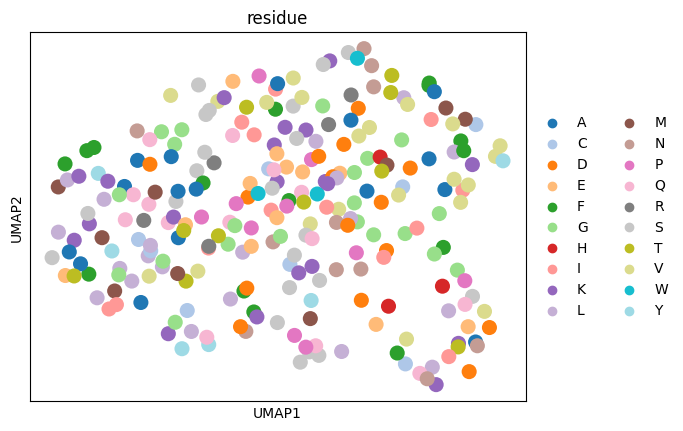

In [77]:
sc.pp.neighbors(adata_dummy, use_rep='X')
sc.tl.umap(adata_dummy)
sc.pl.umap(adata_dummy, color=['residue'], palette="tab20")

## ProtT5

In [92]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pLM_model = "../data/protT5"
prefix_prostT5 = "<AA2fold>"
max_seq_length = 256
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

if "cuda" in device:
    encoder.half()
    print("Using half precision for the pLM encoder")

In [93]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [" ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, :idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class"]
    frst_class.append(classes[:idx])


100it [00:32,  3.12it/s]


In [94]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')

In [95]:
adata

AnnData object with n_obs × n_vars = 24581 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [96]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst

AnnData object with n_obs × n_vars = 11032 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [97]:
sc.pp.pca(adata_frst)
sc.pp.neighbors(adata_frst)
sc.tl.umap(adata_frst)

In [98]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [99]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

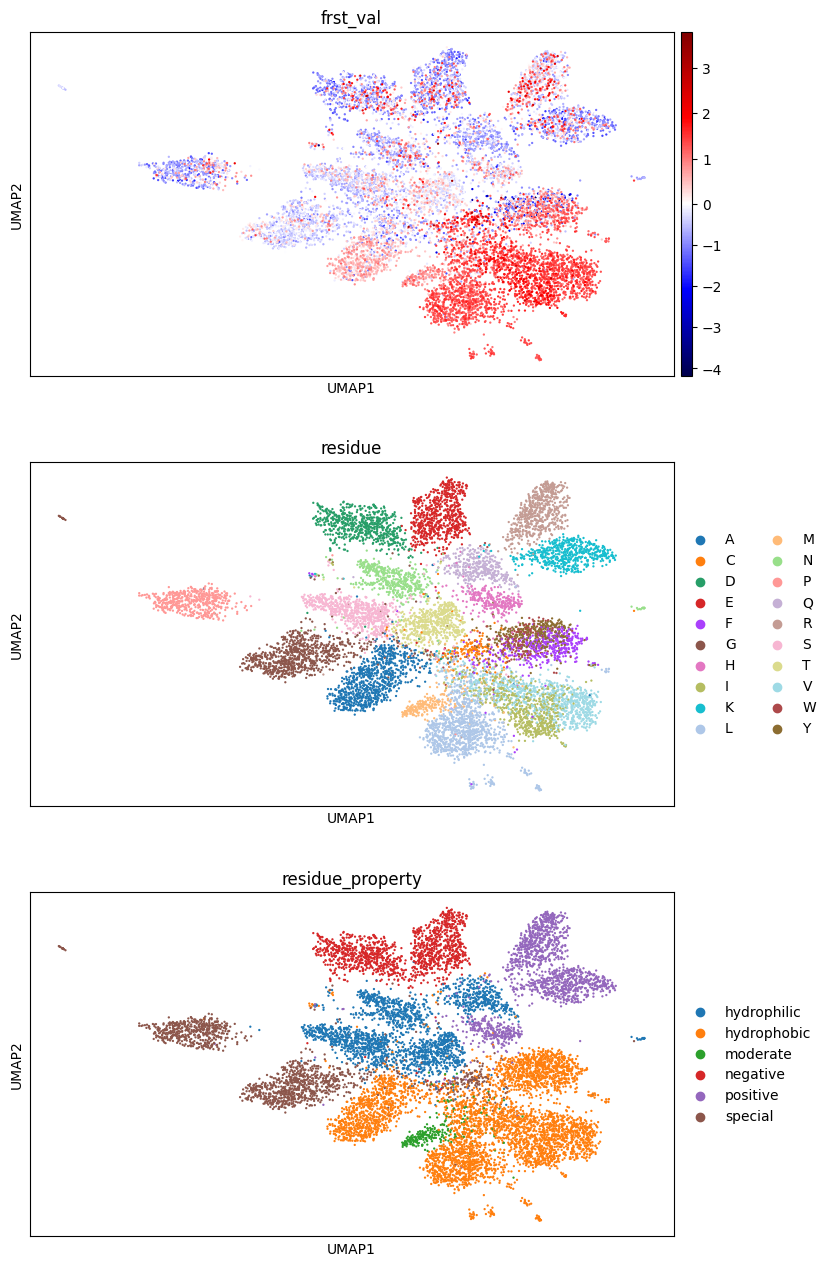

In [101]:
sc.pl.umap(adata_frst, color=['frst_val', 'residue', "residue_property"], ncols=1, wspace=0.4, cmap='seismic', vcenter=0,) #palette="tab20")